In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews_remove_stopwords.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews_remove_stopwords.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
import fastText
EMBEDDING_DIM = 300  # Word vector dimensionality
fasttext_model = fastText.load_model("../input/fasttext_300features_40minwords_10context.bin")

Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(train_clean_reviews, 1))
print(np.random.choice(test_clean_reviews, 1))

['okay reading title would think would good movie well least started good became boring first half hour spoiler tells story mother desperate daughter become cheerleader go lengths get wants problem daughter friend girl way always wins competitions therefore pushing mother towards eliminating talking hitman mother decides girl needs roughed bit actions taken eventually gets caught cast awful movie drags long nothing happening waste time watching']
['cartoon spytroops movie pretty bad four four minutes long yet several battles occur culminating destruction cobra headquarters one downer beginning movie animated battle better rest movie turns kind battle simulation right major turn made rest movie lack credibility issue shipwreck tied along parrot tossed room nobody checked several days whatever happened surveillance cameras cobra base handful characters rest bat robots aside lot corridors cobra base seem weapons tanks trucks equipment silly notion one zero zero complex androids could crea

In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101223 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
print(word_index.items()[0])

('fawn', 29485)


In [10]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
# Null word embeddings is one because index 0 does not match any tokens. keras tokenizer uses 1-based index.

Null word embeddings: 1


In [11]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [12]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [14]:
def cnn_rnn_model(dropout_cnn=0.5, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [15]:
model = cnn_rnn_model()

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30367200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 249, 32)           2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [17]:
# batch_size: number of samples per gradient update
history = model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 292s 15ms/step - loss: 0.4190 - acc: 0.8096 - val_loss: 0.3308 - val_acc: 0.8646
Epoch 2/6
20000/20000 [==============================] - 290s 15ms/step - loss: 0.3119 - acc: 0.8736 - val_loss: 0.3681 - val_acc: 0.8562
Epoch 3/6
20000/20000 [==============================] - 290s 15ms/step - loss: 0.2847 - acc: 0.8857 - val_loss: 0.3282 - val_acc: 0.8628
Epoch 4/6
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2689 - acc: 0.8937 - val_loss: 0.2824 - val_acc: 0.8890
Epoch 5/6
20000/20000 [==============================] - 292s 15ms/step - loss: 0.2549 - acc: 0.8990 - val_loss: 0.3018 - val_acc: 0.8818
Epoch 6/6
20000/20000 [==============================] - 292s 15ms/step - loss: 0.2446 - acc: 0.9035 - val_loss: 0.2632 - val_acc: 0.8926


In [18]:
y_test_pred = model.predict(x_test)

In [19]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [21]:
print("The AUC score for CNN-BiLSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.89932.


In [22]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm_fasttext_remove_stopwords.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm_fasttext_remove_stopwords.csv"

Wrote to cnn_bilstm_fasttext_remove_stopwords.csv


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

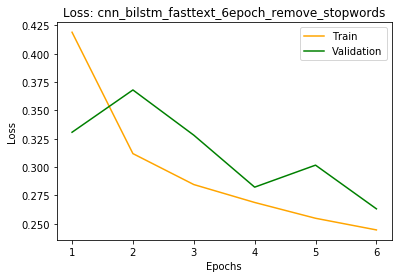

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_fasttext_6epoch_remove_stopwords')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_6epoch_remove_stopwords_loss.png', dpi=900)

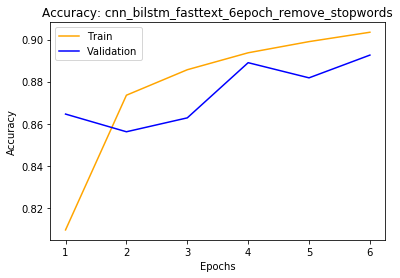

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_fasttext_6epoch_remove_stopwords')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_6epoch_remove_stopwords_accuracy.png', dpi=900)

In [26]:
model.save('cnn_bilstm_fasttext_6epoch_remove_stopwords.h5')

In [27]:
history2 = model.fit(x_train, y_train, batch_size=64, epochs=4, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2248 - acc: 0.9135 - val_loss: 0.2906 - val_acc: 0.8824
Epoch 2/4
20000/20000 [==============================] - 288s 14ms/step - loss: 0.2039 - acc: 0.9224 - val_loss: 0.2764 - val_acc: 0.8936
Epoch 3/4
20000/20000 [==============================] - 288s 14ms/step - loss: 0.1953 - acc: 0.9275 - val_loss: 0.2838 - val_acc: 0.8894
Epoch 4/4
20000/20000 [==============================] - 288s 14ms/step - loss: 0.1777 - acc: 0.9348 - val_loss: 0.3216 - val_acc: 0.8832


In [28]:
from keras.models import load_model

In [29]:
original_model = load_model('cnn_bilstm_fasttext_6epoch_remove_stopwords.h5')

In [31]:
history3 = original_model.fit(x_train, y_train, batch_size=64, epochs=2, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 289s 14ms/step - loss: 0.2273 - acc: 0.9110 - val_loss: 0.3037 - val_acc: 0.8792
Epoch 2/2
20000/20000 [==============================] - 289s 14ms/step - loss: 0.2155 - acc: 0.9155 - val_loss: 0.3226 - val_acc: 0.8730
